# Red wine quality

Practice ML model to determine red wine quality based on Kaggle dataset.

## 1. Imports

Import dependencies required by the app.

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

## 2. Load dataset

Loads the dataset. Prints the first 5 rows to ensure everything is correct.

In [168]:
df = pd.read_csv('./data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Check if there is any null data that needs to be filled in:

In [169]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## 3. Prepare data

There's no null data, so we can continue with processing the dataset. Here, we analyze the features to see what we're working with.

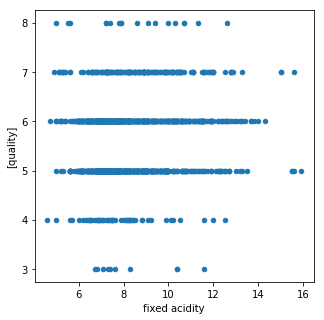

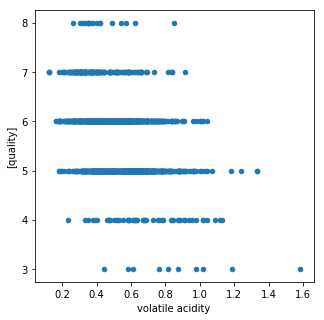

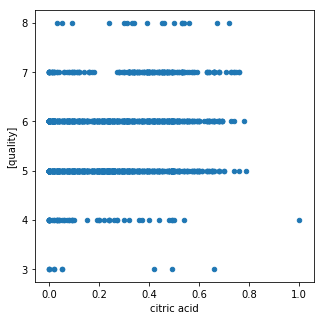

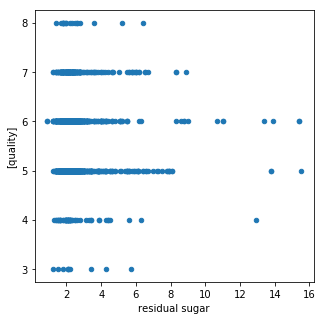

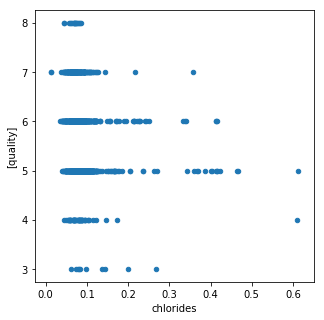

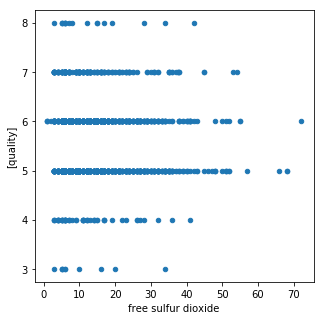

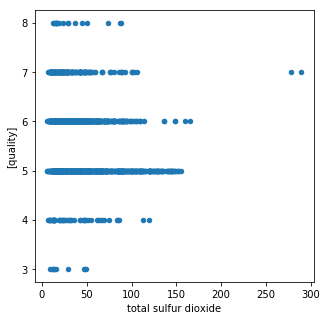

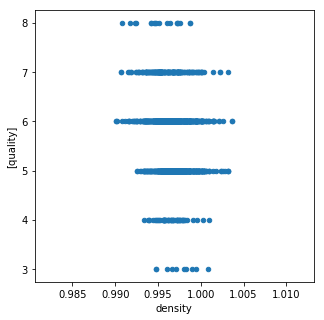

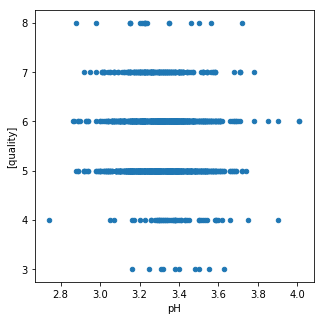

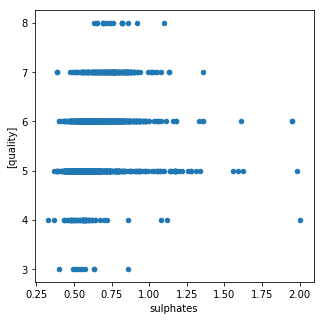

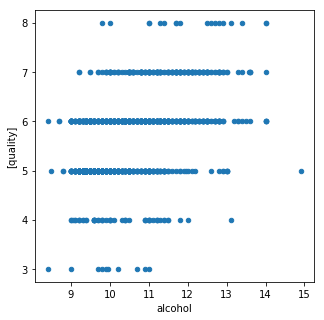

In [170]:
for i in df.columns:
    if i == 'quality':
        continue
    df.plot(x=i, y=["quality"],
                 kind="scatter", figsize=(5, 5))

    # display plot
    mp.show()


Set up the x and y DataFrames. Extract NumPy ndarrays.

In [171]:
x_df = df.drop('quality', axis=1)
y_df = df[['quality']]  

In [172]:
X = x_df.to_numpy()
y = y_df.to_numpy().reshape(len(X), 1)
# Scale all inputs from 0 to 1
print(X.max(axis=0))
X = X / X.max(axis=0)

[ 15.9       1.58      1.       15.5       0.611    72.      289.
   1.00369   4.01      2.       14.9    ]


Insert ones for w_0.

In [173]:
m = np.size(y)
X = np.insert(X, 0, np.ones(m), axis=1)

## 4. Create train/test/validate arrays

Create the train and test NumPy ndarrays with random data from dataset.

In [174]:
nb_samples = X.shape[0]
border1 = int(0.8*nb_samples)
border2 = int(0.9*nb_samples)

indices = np.random.permutation(nb_samples)
train_indices = indices[:border1]
validate_indices = indices[border1:border2]
test_indices = indices[border2:]

X_train = X[train_indices]
y_train = y[train_indices]

X_validate = X[validate_indices]
y_validate = y[validate_indices]

X_test = X[test_indices]
y_test = y[test_indices]

print(nb_samples, len(X_train), len(X_validate), len(X_test))

1599 1279 160 160


## 5. Training

The actual algorithm functions.

In [221]:
def computecost(xx, yy, theta):

    a = 1/(2*m)
    b = np.nansum((np.dot(xx, theta).flatten()-yy.flatten())**2)
    j = (a)*(b)

    return j


def accuracy(xx, yy, theta):
    return ((np.abs(y_test.flatten() - hypothesis(theta, X_test).flatten())) < 1).sum() / y_test.shape[0]
    # return 1 - (np.abs(np.ones(y_test.shape[0]).flatten() - np.divide(y_test.flatten(), hypothesis(theta, X_test).flatten()))).mean()


def gradient_function(y_pred, y_truth):
    out_matrix = (y_pred.flatten() - y_truth.flatten())

    return out_matrix


def hypothesis(theta, xx):
    return np.dot(xx, theta)


def cost(theta, xx, yy):
    return np.sum((np.dot(xx, theta) - yy)**2)


def gradient(xx, yy, theta, iteration):

    alpha = 0.01
    J_history = np.zeros([iteration, 1])

    for iter in range(0, iteration):

        # error = np.dot(xx, theta).flatten() - yy.flatten()
        gradient = gradient_function(hypothesis(theta, xx), yy)
        theta = theta.flatten() - ((alpha/m) * (np.dot(gradient, xx)))
        # compute J value for each iteration
        J_history[iter] = (1 / (2*m)) * cost(theta, xx, yy)
    return theta, J_history


## 6. Run & evaluate

Run the data with a randomly-initialized Theta, and evaluate the results.

In [229]:
theta = np.random.rand(len(X.T), 1)
print(f'Zero computation: {computecost(X_train, y_train, theta)}')
for i in range(200):
    theta, J = gradient(X_train, y_train, theta, 100)
    print(
        f'Iteration {i} Train: {computecost(X_train, y_train, theta)}, Validate: {computecost(X_validate, y_validate, theta)}')

print(f'Test: {computecost(X_test, y_test, theta)}')
print(f'Accuracy: {accuracy(X_test, y_test, theta)*100:.1f}%')

Zero computation: 1.8239970491374917
Iteration 0 Train: 0.24251113917849798, Validate: 0.03003299957749421
Iteration 1 Train: 0.2376561380813251, Validate: 0.02971179757534101
Iteration 2 Train: 0.2358853302282051, Validate: 0.029563645312084656
Iteration 3 Train: 0.2341775397336624, Validate: 0.02941232198695779
Iteration 4 Train: 0.2325247110976533, Validate: 0.029265873947669743
Iteration 5 Train: 0.23092466853888544, Validate: 0.029124494019431423
Iteration 6 Train: 0.2293753421045175, Validate: 0.028987999109780376
Iteration 7 Train: 0.22787475224045492, Validate: 0.028856197524084144
Iteration 8 Train: 0.22642100561543052, Validate: 0.028728905160093063
Iteration 9 Train: 0.22501229116295587, Validate: 0.028605945868898777
Iteration 10 Train: 0.22364687631044555, Validate: 0.02848715112197853
Iteration 11 Train: 0.22232310338640174, Validate: 0.028372359663664786
Iteration 12 Train: 0.2210393861970435, Validate: 0.028261417178710058
Iteration 13 Train: 0.21979420676419134, Valida